In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import  DataLoader
import numpy as np
import pickle

## Data alteration

In [2]:
with open('demand_nyc_full_t.obj', 'rb') as file:
    demand = pickle.load(file)
demand[0][:3]

,x_org,y_org,x_dest,y_dest,t
0,-73.981942,40.719462,-73.938959,40.828984,17
1,-73.965196,40.801107,-73.947489,40.815207,61
2,-73.982236,40.751569,-73.991099,40.750342,74


In [3]:
with open('kpis_nyc.obj', 'rb') as file:
    kpis = pickle.load(file)
kpis[0]

-0.10287356605159516

In [4]:
with open('inData.obj', 'rb') as file:
    inData = pickle.load(file)
with open('params.obj', 'rb') as file:
    params = pickle.load(file)
center = inData.nodes[inData.nodes.index==inData.stats.center]
def centralise(df, center=center, x_name1='x_org', x_name2='x_dest', y_name1='y_org', y_name2='y_dest'):
    df[[x_name1, y_name1, x_name2, y_name2]] -= np.array(center[['x', 'y', 'x', 'y']])[0]
    df[[x_name1, y_name1, x_name2, y_name2]] *= 1000
    return df
demand = list(map(centralise, demand))
demand[0][:5]

,x_org,y_org,x_dest,y_dest,t
0,-14.9090,-52.9937,28.0730,56.5286,17
1,1.8368,28.6516,19.5435,42.7515,61
2,-15.2037,-20.8869,-24.0660,-22.1133,74
3,-15.2037,-20.8869,-18.2031,-33.6204,447
4,-3.0395,-12.8184,-22.1353,-29.4102,80


In [5]:
demand = [torch.tensor(np.matrix(d)) for d in demand]
demand[0].shape

torch.Size([47, 5])

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, demand, labels):
        self.demand = demand
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.demand[index], self.labels[index]

In [7]:
DATASET = Dataset(demand, kpis)

In [8]:
train_size = int(0.8 * len(DATASET))
test_size = len(DATASET) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(DATASET, [train_size, test_size])
print(f'Train size: {train_size}, test size: {test_size}')

Train size: 20770, test size: 5193


In [13]:
torch.save(train_dataset, 'nyc_full_train.pt')
torch.save(test_dataset, 'nyc_full_test.pt')

## Data inspection

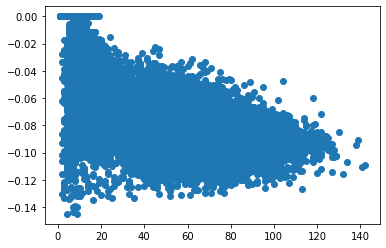

In [9]:
import matplotlib.pyplot as plt

x = [len(d) for d in demand]
plt.scatter(x, kpis)

## NN

In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_features, nh1, nh2):
        super(Net, self).__init__()
        self.h1 = torch.nn.Linear(n_features, nh1)
        self.h2 = torch.nn.Linear(nh1, nh2)
        self.predict = torch.nn.Linear(nh2*5, 1)

    def forward(self, x):
        x = F.LeakyReLU(self.h1(x))
        x = F.LeakyReLU(self.h2(x))
        x = torch.flatten(x)
        x = self.predict(x)
        return x

In [14]:
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 256

nh1 = 32
nh2 = 64

lr = 1e-3
epochs = 30
DEVICE

device(type='cuda')

In [ ]:
train_dataset = torch.load('nyc_grid_shifted_train_dataset.pt')
test_dataset = torch.load('nyc_grid_shifted_test_dataset.pt')

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size=len(test_loader), shuffle=True, num_workers = 4)

In [17]:
net = Net(5, nh1, nh2).to(DEVICE)

criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr)

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_losses_train = []
    epoch_losses_test = []
    
    for i, data in enumerate(train_loader):
        inputs, kpis = data
        
        inputs = inputs.to(DEVICE)
        kpis = kpis.to(DEVICE)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, kpis)
        loss.backward()
        optimizer.step()

        epoch_losses_train.append(loss.item())

        x, y = next(iter(test_loader))
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        loss = criterion(y, net(x))
        epoch_losses_test.append(loss.item())

    train_loss.append(np.mean(epoch_losses_train))
    test_loss.append(np.mean(epoch_losses_test))
    if epoch % 10 == 9:
        print(f' ####### Epoch: {epoch} #######')
        print(f'Train loss: {train_loss[epoch]:.4f}')
        print(f'Test loss: {test_loss[epoch]:.4f}')
        print('\n')
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.legend(title='Loss with respect to epoch')
plt.show()